In [1]:
# Cell 1 - Import required libraries
import numpy as np
import pandas as pd
import glob
import os
import tensorflow as tf
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.saving import register_keras_serializable
import joblib
import xlsxwriter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cell 2 - Define Transformer model classes (needed for loading the saved model)
@register_keras_serializable()
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.key_dense = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.value_dense = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.combine_heads = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.dropout = layers.Dropout(dropout_rate)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
        })
        return config

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        weights = self.dropout(weights)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

@register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = MultiHeadSelfAttention(embed_dim, num_heads, rate)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=l2(0.01)),
            layers.Dropout(rate),
            layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

@register_keras_serializable()
class TransformerClassifier(Model):
    def __init__(self, num_classes, embed_dim, num_heads, ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        
        self.input_norm = layers.BatchNormalization()
        self.dense_input = layers.Dense(embed_dim, kernel_regularizer=l2(0.01))
        self.input_dropout = layers.Dropout(0.2)
        
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        self.dropout1 = layers.Dropout(0.2)
        self.dense1 = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01))
        self.dropout2 = layers.Dropout(0.2)
        self.dense2 = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01))

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    def call(self, inputs, training=False):
        x = self.input_norm(inputs)
        x = self.dense_input(x)
        x = self.input_dropout(x, training=training)
        
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)
            
        x = self.global_average_pooling(x)
        x = self.dropout1(x, training=training)
        x = self.dense1(x)
        x = self.dropout2(x, training=training)
        return self.dense2(x)

In [3]:
# Cell 3 - Define feature extraction functions
def extract_time_domain_features(data):
    """Extract time domain features from the input data"""
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    mins = np.min(data, axis=1)
    maxs = np.max(data, axis=1)
    percentile_25 = np.percentile(data, 25, axis=1)
    percentile_50 = np.percentile(data, 50, axis=1)
    percentile_75 = np.percentile(data, 75, axis=1)
    
    time_features = np.column_stack([
        means, stds, mins, maxs,
        percentile_25, percentile_50, percentile_75
    ])
    
    return time_features

def extract_frequency_domain_features(data):
    """Extract frequency domain features from the input data"""
    freq_features = np.fft.fft(data, axis=1)
    freq_magnitude = np.abs(freq_features)
    
    dominant_freqs = np.argmax(freq_magnitude, axis=1)
    freq_energies = np.sum(freq_magnitude, axis=1)
    
    freq_features = np.column_stack([dominant_freqs, freq_energies])
    
    return freq_features

def extract_statistical_features(data):
    """Extract statistical features from the input data"""
    means = np.mean(data, axis=1)
    medians = np.median(data, axis=1)
    variances = np.var(data, axis=1)
    skewness = skew(data, axis=1)
    kurtosis_vals = kurtosis(data, axis=1)
    
    statistical_features = np.column_stack([
        means, medians, variances, skewness, kurtosis_vals
    ])
    
    return statistical_features

In [4]:
# Cell 4 - Define preprocessing and classification functions
def load_and_preprocess_file(file_path, scaler):
    """
    Load and preprocess a single file for classification
    """
    try:
        # Read the file
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]

        # Convert to DataFrame
        df = pd.DataFrame([line.split() for line in lines])
        
        if df.empty:
            raise ValueError(f"File is empty after processing")

        # First row contains total number of rows
        total_rows = int(df.iloc[0, 0])
        
        # Extract feature data
        data = df.iloc[1:, :].values
        
        # Ensure each row has 7 features
        reshaped_data = []
        for row in data:
            if len(row) == 7:
                reshaped_data.append(row)
        
        if not reshaped_data:
            raise ValueError("No valid data rows found")
        
        # Convert to numpy array
        reshaped_data = np.array(reshaped_data, dtype=float)
        
        # Extract features
        time_features = extract_time_domain_features(reshaped_data)
        freq_features = extract_frequency_domain_features(reshaped_data)
        stat_features = extract_statistical_features(reshaped_data)
        
        # Combine features
        combined_features = np.concatenate((time_features, freq_features, stat_features), axis=1)
        combined_features = scaler.transform(combined_features)
        return combined_features
        
    except Exception as e:
        raise Exception(f"Error processing file {file_path}: {e}")

def batch_classify_emotions(model_path, scaler_path, directory_path, results_file):
    """
    Batch classify emotions in a directory with progress bar and detailed tracking.
    Results are logged in a file and printed in the notebook.
    """
    # Load model and scaler
    model = load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    # Define label mapping
    label_map = {'0': 'Normal', '1': 'Depression', '2': 'Anxiety', '3': 'Stress'}
    class_labels = ['Normal', 'Depression', 'Anxiety', 'Stress']
    
    # Find all .svc files
    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    
    if not file_paths:
        raise ValueError("No .svc files found in the directory")
    
    # Prepare dictionaries to store results
    base_filename_correct_files = {}
    base_filename_all_files = {}
    true_labels = []
    predicted_labels = []
    classification_results = []
    
    # Clear existing results file
    open(results_file, 'w').close()
    
    # Process files with progress bar
    with tqdm(file_paths, desc="Classifying Files", unit="file") as pbar:
        for file_path in pbar:
            try:
                # Extract true label from filename
                filename = os.path.basename(file_path)
                
                # Extract base filename (everything before hw)
                base_filename = filename.split('hw')[0]
                
                # Ensure base filename is in our tracking dictionaries
                if base_filename not in base_filename_correct_files:
                    base_filename_correct_files[base_filename] = []
                if base_filename not in base_filename_all_files:
                    base_filename_all_files[base_filename] = []
                
                label_key = filename[0]
                true_label = label_map.get(label_key)
                
                # Preprocess file
                features = load_and_preprocess_file(file_path, scaler)
                
                # Predict emotions for each row
                predictions = model.predict(features)
                predicted_classes = np.argmax(predictions, axis=1)
                
                # Find the most frequent class
                unique_classes, class_counts = np.unique(predicted_classes, return_counts=True)
                most_frequent_class_index = unique_classes[np.argmax(class_counts)]
                final_prediction = class_labels[most_frequent_class_index]
                
                # Calculate confidence
                confidence = (np.max(class_counts) / len(predicted_classes)) * 100
                
                # Detailed confidence levels
                emotion_confidences = [
                    (label, float(np.mean(predictions[:, i]) * 100)) 
                    for i, label in enumerate(class_labels)
                ]
                emotion_confidences.sort(key=lambda x: x[1], reverse=True)
                
                # Prepare results string
                results_str = f"{filename}: Predicted Emotion - {final_prediction} | " + \
                              "Confidence Levels: " + \
                              ", ".join([f"{emotion}: {conf:.2f}%" for emotion, conf in emotion_confidences])
                
                # Print classification result
                print(results_str)
                
                # Log results
                with open(results_file, 'a') as f:
                    f.write(results_str + '\n')
                
                # Track classifications
                true_labels.append(true_label)
                predicted_labels.append(final_prediction)
                
                # Store classification result
                classification_results.append({
                    'Filename': filename,
                    'True Label': true_label,
                    'Predicted Label': final_prediction,
                    **{f'{emotion} Confidence': conf for emotion, conf in emotion_confidences}
                })
                
                # Track files for base filename
                base_filename_all_files[base_filename].append(filename)
                
                # If classification is correct, add to correct files
                if true_label == final_prediction:
                    base_filename_correct_files[base_filename].append(filename)
                
                # Update progress bar description
                pbar.set_description(f"Classifying {filename}")
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue
    
    # Calculate overall accuracy
    accuracy = sum(t == p for t, p in zip(true_labels, predicted_labels)) / len(true_labels) * 100
    
    # Print overall accuracy
    print(f"\nOverall Classification Accuracy: {accuracy:.2f}%")
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    
    # Prepare DataFrame for classification results
    df_results = pd.DataFrame(classification_results)
    
    return df_results, cm, accuracy, true_labels, predicted_labels


def create_classification_report(true_labels, predicted_labels, class_labels, output_file):
    """
    Generate a detailed classification report
    """
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    
    # Write report to file
    with open(output_file, 'w') as f:
        f.write(report)
    
    print(f"\nDetailed Classification Report saved to {output_file}")
    print(report)

def classify_emotion(model_path, scaler_path, file_path, results_file):
    try:
        # Load model and scaler
        model = load_model(model_path)
        scaler = joblib.load(scaler_path)
        
        filename = os.path.basename(file_path)
        
        # Process the input file
        features = load_and_preprocess_file(file_path, scaler)
        
        # Predict emotions for each row
        predictions = model.predict(features)
        
        # Get the predicted class for each row
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Count occurrences of each class
        class_labels = ['Normal', 'Depression', 'Anxiety', 'Stress']
        unique_classes, class_counts = np.unique(predicted_classes, return_counts=True)
        
        # Find the most frequent class
        most_frequent_class_index = unique_classes[np.argmax(class_counts)]
        final_prediction = class_labels[most_frequent_class_index]
        
        # Calculate confidence as the proportion of rows with this prediction
        confidence = (np.max(class_counts) / len(predicted_classes)) * 100
        
        # Detailed confidence levels
        emotion_confidences = [
            (label, float(np.mean(predictions[:, i]) * 100)) 
            for i, label in enumerate(class_labels)
        ]
        emotion_confidences.sort(key=lambda x: x[1], reverse=True)
        
        # Prepare results string
        results_str = f"{filename}: Predicted Emotion - {final_prediction} | " + \
                      "Confidence Levels: " + \
                      ", ".join([f"{emotion}: {conf:.2f}%" for emotion, conf in emotion_confidences])
        
        # Print and log results
        print(results_str)
        with open(results_file, 'a') as f:
            f.write(results_str + '\n')
        
        return final_prediction, emotion_confidences
        
    except Exception as e:
        error_msg = f"Error processing {filename}: {e}"
        print(error_msg)
        with open(results_file, 'a') as f:
            f.write(error_msg + '\n')
        raise

def plot_confusion_matrix(cm, class_labels):
    """
    Plot the confusion matrix using seaborn heatmap
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

Classifying Files:   0%|          | 0/182 [00:00<?, ?file/s]

83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


Classifying 0_u00003s00001hw00001.svc:   1%|          | 1/182 [00:02<08:55,  2.96s/file]

0_u00003s00001hw00001.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 54.67%, Depression: 28.97%, Anxiety: 16.33%, Stress: 0.03%
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


Classifying 0_u00003s00001hw00002.svc:   1%|          | 2/182 [00:06<09:42,  3.23s/file]

0_u00003s00001hw00002.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 48.67%, Anxiety: 27.37%, Depression: 23.79%, Stress: 0.16%
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
0_u00003s00001hw00003.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 45.37%, Anxiety: 30.93%, Depression: 23.69%, Stress: 0.01%


Classifying 0_u00003s00001hw00003.svc:   2%|▏         | 3/182 [00:08<08:21,  2.80s/file]

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 0_u00003s00001hw00004.svc:   2%|▏         | 4/182 [00:09<05:57,  2.01s/file]

0_u00003s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 85.58%, Normal: 8.34%, Depression: 6.06%, Stress: 0.01%
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0_u00003s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 82.42%, Normal: 9.96%, Depression: 6.40%, Stress: 1.22%

Classifying 0_u00003s00001hw00005.svc:   3%|▎         | 5/182 [00:10<04:31,  1.53s/file]


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Classifying 0_u00003s00001hw00006.svc:   3%|▎         | 6/182 [00:12<05:03,  1.72s/file]

0_u00003s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 55.29%, Depression: 24.63%, Normal: 19.56%, Stress: 0.51%
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 0_u00003s00001hw00007.svc:   4%|▍         | 7/182 [00:14<05:09,  1.77s/file]

0_u00003s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 73.38%, Depression: 13.15%, Normal: 12.58%, Stress: 0.88%
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 0_u00013s00001hw00001.svc:   4%|▍         | 8/182 [00:15<04:31,  1.56s/file]

0_u00013s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 77.74%, Anxiety: 17.93%, Normal: 4.14%, Depression: 0.19%
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 0_u00013s00001hw00002.svc:   5%|▍         | 9/182 [00:17<04:57,  1.72s/file]

0_u00013s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 75.54%, Stress: 16.20%, Normal: 7.73%, Depression: 0.53%
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
0_u00013s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 90.36%, Normal: 6.76%, Depression: 2.85%, Stress: 0.04%


Classifying 0_u00013s00001hw00003.svc:   5%|▌         | 10/182 [00:19<05:16,  1.84s/file]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0_u00013s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 69.32%, Normal: 19.40%, Depression: 11.25%, Stress: 0.03%

Classifying 0_u00013s00001hw00004.svc:   6%|▌         | 11/182 [00:19<04:06,  1.44s/file]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying 0_u00013s00001hw00005.svc:   7%|▋         | 12/182 [00:20<03:16,  1.16s/file]

0_u00013s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 96.34%, Normal: 2.96%, Depression: 0.61%, Stress: 0.08%
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 0_u00013s00001hw00006.svc:   7%|▋         | 13/182 [00:22<04:18,  1.53s/file]

0_u00013s00001hw00006.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 36.93%, Depression: 33.88%, Anxiety: 29.19%, Stress: 0.01%
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
0_u00013s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 46.80%, Normal: 32.74%, Depression: 20.44%, Stress: 0.02%

Classifying 0_u00013s00001hw00007.svc:   8%|▊         | 14/182 [00:25<04:53,  1.75s/file]


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 0_u00015s00001hw00001.svc:   8%|▊         | 15/182 [00:26<04:31,  1.63s/file]

0_u00015s00001hw00001.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 51.99%, Depression: 32.49%, Anxiety: 15.51%, Stress: 0.00%
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
0_u00015s00001hw00002.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 48.66%, Anxiety: 27.33%, Depression: 23.98%, Stress: 0.03%


Classifying 0_u00015s00001hw00002.svc:   9%|▉         | 16/182 [00:28<05:00,  1.81s/file]

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
0_u00015s00001hw00003.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 53.57%, Anxiety: 23.60%, Depression: 22.79%, Stress: 0.04%


Classifying 0_u00015s00001hw00003.svc:   9%|▉         | 17/182 [00:30<05:15,  1.91s/file]

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0_u00015s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 48.81%, Anxiety: 29.75%, Normal: 21.42%, Stress: 0.02%


Classifying 0_u00015s00001hw00004.svc:  10%|▉         | 18/182 [00:31<04:08,  1.51s/file]

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Classifying 0_u00015s00001hw00005.svc:  10%|█         | 19/182 [00:32<03:32,  1.30s/file]

0_u00015s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 81.79%, Normal: 11.62%, Depression: 6.08%, Stress: 0.51%
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Classifying 0_u00015s00001hw00006.svc:  10%|█         | 19/182 [00:33<03:32,  1.30s/file]

0_u00015s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 73.75%, Normal: 14.55%, Depression: 11.13%, Stress: 0.56%


Classifying 0_u00015s00001hw00006.svc:  11%|█         | 20/182 [00:33<03:39,  1.36s/file]

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 0_u00015s00001hw00007.svc:  12%|█▏        | 21/182 [00:35<04:06,  1.53s/file]

0_u00015s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 55.84%, Normal: 25.29%, Depression: 13.67%, Stress: 5.21%
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 0_u00027s00001hw00001.svc:  12%|█▏        | 22/182 [00:37<04:24,  1.65s/file]

0_u00027s00001hw00001.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 53.68%, Depression: 34.66%, Anxiety: 11.65%, Stress: 0.01%
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
0_u00027s00001hw00002.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 53.37%, Depression: 35.26%, Anxiety: 11.21%, Stress: 0.17%


Classifying 0_u00027s00001hw00002.svc:  13%|█▎        | 23/182 [00:39<04:35,  1.73s/file]

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
0_u00027s00001hw00003.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 57.25%, Depression: 31.80%, Anxiety: 10.84%, Stress: 0.11%

Classifying 0_u00027s00001hw00003.svc:  13%|█▎        | 24/182 [00:41<05:05,  1.93s/file]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Classifying 0_u00027s00001hw00004.svc:  14%|█▎        | 25/182 [00:42<04:03,  1.55s/file]

0_u00027s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 79.64%, Normal: 17.87%, Anxiety: 2.48%, Stress: 0.00%
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Classifying 0_u00027s00001hw00005.svc:  14%|█▍        | 26/182 [00:43<03:16,  1.26s/file]

0_u00027s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 59.43%, Normal: 21.41%, Depression: 13.49%, Stress: 5.68%
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
0_u00027s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 46.48%, Depression: 25.98%, Normal: 24.78%, Stress: 2.76%


Classifying 0_u00027s00001hw00006.svc:  15%|█▍        | 27/182 [00:44<03:36,  1.39s/file]

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 0_u00027s00001hw00007.svc:  15%|█▌        | 28/182 [00:48<05:13,  2.04s/file]

0_u00027s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 31.89%, Depression: 29.40%, Normal: 29.25%, Stress: 9.46%
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
0_u00035s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 92.02%, Normal: 7.26%, Depression: 0.55%, Anxiety: 0.17%


Classifying 0_u00035s00001hw00001.svc:  16%|█▌        | 29/182 [00:49<04:29,  1.76s/file]

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 0_u00035s00001hw00002.svc:  16%|█▋        | 30/182 [00:51<04:26,  1.75s/file]

0_u00035s00001hw00002.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.75%, Normal: 2.04%, Anxiety: 0.17%, Depression: 0.03%
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 0_u00035s00001hw00003.svc:  17%|█▋        | 31/182 [00:53<04:36,  1.83s/file]

0_u00035s00001hw00003.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 53.86%, Anxiety: 37.33%, Normal: 8.36%, Depression: 0.44%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0_u00035s00001hw00004.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 72.11%, Depression: 14.49%, Anxiety: 13.39%, Stress: 0.00%


Classifying 0_u00035s00001hw00004.svc:  18%|█▊        | 32/182 [00:53<03:27,  1.38s/file]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying 0_u00035s00001hw00005.svc:  18%|█▊        | 33/182 [00:54<02:45,  1.11s/file]

0_u00035s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 64.41%, Normal: 18.06%, Stress: 16.72%, Depression: 0.81%
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
0_u00035s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 46.04%, Normal: 39.05%, Depression: 14.87%, Stress: 0.05%


Classifying 0_u00035s00001hw00006.svc:  19%|█▊        | 34/182 [00:55<02:52,  1.17s/file]

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 0_u00035s00001hw00007.svc:  19%|█▉        | 35/182 [00:57<03:41,  1.50s/file]

0_u00035s00001hw00007.svc: Predicted Emotion - Normal | Confidence Levels: Anxiety: 42.26%, Normal: 40.83%, Depression: 16.68%, Stress: 0.23%
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
0_u00040s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.26%, Normal: 2.31%, Depression: 0.42%, Anxiety: 0.01%

Classifying 0_u00040s00001hw00001.svc:  20%|█▉        | 36/182 [00:59<03:35,  1.48s/file]


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
0_u00040s00001hw00002.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 73.36%, Normal: 26.56%, Depression: 0.05%, Anxiety: 0.03%


Classifying 0_u00040s00001hw00002.svc:  20%|██        | 37/182 [01:00<03:37,  1.50s/file]

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
0_u00040s00001hw00003.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 77.27%, Stress: 21.82%, Anxiety: 0.70%, Depression: 0.21%


Classifying 0_u00040s00001hw00003.svc:  21%|██        | 38/182 [01:02<03:43,  1.55s/file]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
0_u00040s00001hw00004.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 84.20%, Anxiety: 11.97%, Depression: 3.77%, Stress: 0.06%


Classifying 0_u00040s00001hw00004.svc:  21%|██▏       | 39/182 [01:02<03:01,  1.27s/file]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0_u00040s00001hw00005.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 62.16%, Anxiety: 21.71%, Normal: 15.65%, Depression: 0.47%

Classifying 0_u00040s00001hw00005.svc:  22%|██▏       | 40/182 [01:03<02:31,  1.07s/file]


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
0_u00040s00001hw00006.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 58.93%, Depression: 27.42%, Anxiety: 13.64%, Stress: 0.01%

Classifying 0_u00040s00001hw00006.svc:  23%|██▎       | 41/182 [01:04<02:43,  1.16s/file]


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
0_u00040s00001hw00007.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 71.01%, Depression: 17.45%, Anxiety: 11.52%, Stress: 0.01%

Classifying 0_u00040s00001hw00007.svc:  23%|██▎       | 42/182 [01:06<02:54,  1.25s/file]


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Classifying 0_u00044s00001hw00001.svc:  24%|██▎       | 43/182 [01:07<02:58,  1.28s/file]

0_u00044s00001hw00001.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 42.97%, Anxiety: 36.52%, Depression: 20.51%, Stress: 0.00%
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 0_u00044s00001hw00002.svc:  24%|██▍       | 44/182 [01:10<03:55,  1.71s/file]

0_u00044s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 65.97%, Normal: 21.77%, Depression: 12.26%, Stress: 0.01%
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 0_u00044s00001hw00003.svc:  25%|██▍       | 45/182 [01:11<03:48,  1.67s/file]

0_u00044s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 71.64%, Normal: 22.00%, Depression: 6.33%, Stress: 0.02%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Classifying 0_u00044s00001hw00004.svc:  25%|██▌       | 46/182 [01:12<02:50,  1.25s/file]

0_u00044s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 84.71%, Normal: 13.74%, Anxiety: 1.55%, Stress: 0.00%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying 0_u00044s00001hw00005.svc:  26%|██▌       | 47/182 [01:12<02:14,  1.01file/s]

0_u00044s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 97.74%, Normal: 1.71%, Depression: 0.52%, Stress: 0.02%
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
0_u00044s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 90.06%, Normal: 5.26%, Depression: 4.66%, Stress: 0.02%

Classifying 0_u00044s00001hw00006.svc:  26%|██▋       | 48/182 [01:13<02:19,  1.04s/file]


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
0_u00044s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 92.61%, Normal: 3.91%, Depression: 1.84%, Stress: 1.64%


Classifying 0_u00044s00001hw00007.svc:  27%|██▋       | 49/182 [01:15<02:36,  1.18s/file]

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 1_u00010s00001hw00001.svc:  27%|██▋       | 50/182 [01:16<02:36,  1.19s/file]

1_u00010s00001hw00001.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 72.67%, Stress: 27.33%, Normal: 0.00%, Anxiety: 0.00%
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Classifying 1_u00010s00001hw00002.svc:  28%|██▊       | 51/182 [01:18<02:53,  1.32s/file]

1_u00010s00001hw00002.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 85.54%, Stress: 14.46%, Normal: 0.00%, Anxiety: 0.00%
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 1_u00010s00001hw00003.svc:  29%|██▊       | 52/182 [01:19<03:09,  1.45s/file]

1_u00010s00001hw00003.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 84.39%, Stress: 15.61%, Normal: 0.00%, Anxiety: 0.00%
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 1_u00010s00001hw00004.svc:  29%|██▉       | 53/182 [01:20<02:51,  1.33s/file]

1_u00010s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 64.73%, Stress: 35.16%, Anxiety: 0.08%, Normal: 0.02%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Classifying 1_u00010s00001hw00005.svc:  30%|██▉       | 54/182 [01:21<02:21,  1.11s/file]

1_u00010s00001hw00005.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 89.42%, Stress: 10.58%, Normal: 0.00%, Anxiety: 0.00%
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
1_u00010s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 84.92%, Stress: 15.08%, Normal: 0.00%, Anxiety: 0.00%


Classifying 1_u00010s00001hw00006.svc:  30%|███       | 55/182 [01:22<02:35,  1.23s/file]

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1_u00010s00001hw00007.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 89.31%, Stress: 10.69%, Normal: 0.00%, Anxiety: 0.00%


Classifying 1_u00010s00001hw00007.svc:  31%|███       | 56/182 [01:24<02:39,  1.26s/file]

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 1_u00011s00001hw00001.svc:  31%|███▏      | 57/182 [01:25<02:45,  1.33s/file]

1_u00011s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 84.10%, Depression: 15.90%, Normal: 0.00%, Anxiety: 0.00%
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 1_u00011s00001hw00002.svc:  32%|███▏      | 58/182 [01:27<02:56,  1.42s/file]

1_u00011s00001hw00002.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 80.11%, Depression: 19.89%, Normal: 0.00%, Anxiety: 0.00%
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 1_u00011s00001hw00003.svc:  32%|███▏      | 59/182 [01:29<03:10,  1.55s/file]

1_u00011s00001hw00003.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 74.65%, Depression: 25.35%, Normal: 0.00%, Anxiety: 0.00%
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 1_u00011s00001hw00004.svc:  32%|███▏      | 59/182 [01:30<03:10,  1.55s/file]

1_u00011s00001hw00004.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 66.25%, Depression: 33.06%, Anxiety: 0.43%, Normal: 0.26%


Classifying 1_u00011s00001hw00004.svc:  33%|███▎      | 60/182 [01:30<02:44,  1.35s/file]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1_u00011s00001hw00005.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 64.45%, Depression: 35.53%, Normal: 0.02%, Anxiety: 0.00%

Classifying 1_u00011s00001hw00005.svc:  34%|███▎      | 61/182 [01:30<02:17,  1.14s/file]


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1_u00011s00001hw00006.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 76.52%, Depression: 23.48%, Normal: 0.01%, Anxiety: 0.00%

Classifying 1_u00011s00001hw00006.svc:  34%|███▍      | 62/182 [01:31<02:13,  1.11s/file]


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 1_u00011s00001hw00007.svc:  35%|███▍      | 63/182 [01:33<02:23,  1.20s/file]

1_u00011s00001hw00007.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 73.73%, Depression: 26.27%, Normal: 0.01%, Anxiety: 0.00%
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Classifying 1_u00021s00001hw00001.svc:  35%|███▍      | 63/182 [01:34<02:23,  1.20s/file]

1_u00021s00001hw00001.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 74.03%, Normal: 15.45%, Anxiety: 10.53%, Stress: 0.00%


Classifying 1_u00021s00001hw00001.svc:  35%|███▌      | 64/182 [01:34<02:34,  1.31s/file]

177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


Classifying 1_u00021s00001hw00002.svc:  36%|███▌      | 65/182 [01:37<03:32,  1.82s/file]

1_u00021s00001hw00002.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 61.96%, Normal: 19.65%, Anxiety: 18.39%, Stress: 0.00%
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
1_u00021s00001hw00003.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 48.71%, Anxiety: 27.03%, Normal: 24.25%, Stress: 0.00%


Classifying 1_u00021s00001hw00003.svc:  36%|███▋      | 66/182 [01:39<03:35,  1.86s/file]

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 1_u00021s00001hw00004.svc:  37%|███▋      | 67/182 [01:40<03:00,  1.57s/file]

1_u00021s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 39.61%, Anxiety: 36.17%, Normal: 24.21%, Stress: 0.01%
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 1_u00021s00001hw00005.svc:  37%|███▋      | 68/182 [01:41<02:30,  1.32s/file]

1_u00021s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 48.83%, Depression: 28.43%, Normal: 22.74%, Stress: 0.00%
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


Classifying 1_u00021s00001hw00006.svc:  38%|███▊      | 69/182 [01:45<03:46,  2.00s/file]

1_u00021s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 61.84%, Normal: 19.20%, Anxiety: 18.96%, Stress: 0.00%
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
1_u00021s00001hw00007.svc: Predicted Emotion - Depression | Confidence Levels: Anxiety: 41.31%, Depression: 39.98%, Normal: 18.70%, Stress: 0.00%


Classifying 1_u00021s00001hw00007.svc:  38%|███▊      | 70/182 [01:46<03:40,  1.97s/file]

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1_u00038s00001hw00001.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 43.88%, Anxiety: 35.67%, Normal: 20.45%, Stress: 0.00%

Classifying 1_u00038s00001hw00001.svc:  39%|███▉      | 71/182 [01:48<03:24,  1.84s/file]


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1_u00038s00001hw00002.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 43.38%, Anxiety: 39.62%, Normal: 17.01%, Stress: 0.00%


Classifying 1_u00038s00001hw00002.svc:  40%|███▉      | 72/182 [01:50<03:13,  1.76s/file]

139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 1_u00038s00001hw00003.svc:  40%|████      | 73/182 [01:52<03:32,  1.95s/file]

1_u00038s00001hw00003.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 53.98%, Anxiety: 24.12%, Normal: 21.90%, Stress: 0.00%
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1_u00038s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 50.57%, Depression: 25.16%, Normal: 24.27%, Stress: 0.01%


Classifying 1_u00038s00001hw00004.svc:  41%|████      | 74/182 [01:52<02:43,  1.51s/file]

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1_u00038s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 84.83%, Normal: 9.95%, Depression: 5.22%, Stress: 0.00%

Classifying 1_u00038s00001hw00005.svc:  41%|████      | 75/182 [01:53<02:13,  1.25s/file]


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
1_u00038s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 56.53%, Normal: 29.94%, Anxiety: 13.53%, Stress: 0.00%


Classifying 1_u00038s00001hw00006.svc:  42%|████▏     | 76/182 [01:54<02:09,  1.22s/file]

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1_u00038s00001hw00007.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 41.38%, Anxiety: 30.70%, Depression: 27.90%, Stress: 0.01%


Classifying 1_u00038s00001hw00007.svc:  42%|████▏     | 77/182 [01:56<02:21,  1.35s/file]

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00001s00001hw00001.svc:  43%|████▎     | 78/182 [01:57<02:05,  1.21s/file]

2_u00001s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 76.40%, Anxiety: 18.55%, Normal: 4.82%, Depression: 0.23%
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00001s00001hw00002.svc:  43%|████▎     | 79/182 [01:58<02:16,  1.33s/file]

2_u00001s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 50.11%, Stress: 34.65%, Normal: 14.59%, Depression: 0.64%
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
2_u00001s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 82.62%, Normal: 11.87%, Depression: 5.47%, Stress: 0.04%


Classifying 2_u00001s00001hw00003.svc:  44%|████▍     | 80/182 [02:00<02:31,  1.49s/file]

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00001s00001hw00004.svc:  45%|████▍     | 81/182 [02:01<02:21,  1.40s/file]

2_u00001s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 59.78%, Normal: 23.30%, Depression: 16.89%, Stress: 0.03%
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00001s00001hw00005.svc:  45%|████▌     | 82/182 [02:02<02:00,  1.21s/file]

2_u00001s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 96.05%, Normal: 3.32%, Depression: 0.53%, Stress: 0.10%
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00001s00001hw00006.svc:  46%|████▌     | 83/182 [02:04<02:06,  1.28s/file]

2_u00001s00001hw00006.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 39.56%, Anxiety: 31.74%, Depression: 28.70%, Stress: 0.01%
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00001s00001hw00007.svc:  46%|████▌     | 84/182 [02:05<02:18,  1.41s/file]

2_u00001s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 46.85%, Normal: 34.77%, Depression: 18.37%, Stress: 0.01%
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00002s00001hw00001.svc:  47%|████▋     | 85/182 [02:07<02:11,  1.36s/file]

2_u00002s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 52.62%, Depression: 29.96%, Normal: 17.42%, Stress: 0.00%
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 2_u00002s00001hw00002.svc:  47%|████▋     | 85/182 [02:09<02:11,  1.36s/file]

2_u00002s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 59.14%, Depression: 27.70%, Normal: 13.16%, Stress: 0.00%


Classifying 2_u00002s00001hw00002.svc:  47%|████▋     | 86/182 [02:09<02:30,  1.57s/file]

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 2_u00002s00001hw00003.svc:  48%|████▊     | 87/182 [02:11<02:51,  1.81s/file]

2_u00002s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 63.05%, Depression: 24.20%, Normal: 12.75%, Stress: 0.00%
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


Classifying 2_u00002s00001hw00004.svc:  48%|████▊     | 88/182 [02:12<02:23,  1.52s/file]

2_u00002s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 79.38%, Normal: 18.30%, Anxiety: 2.31%, Stress: 0.00%
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2_u00002s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 98.64%, Normal: 0.98%, Depression: 0.38%, Stress: 0.00%


Classifying 2_u00002s00001hw00005.svc:  49%|████▉     | 89/182 [02:12<01:55,  1.25s/file]

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2_u00002s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 65.02%, Depression: 20.48%, Normal: 14.50%, Stress: 0.00%


Classifying 2_u00002s00001hw00006.svc:  49%|████▉     | 90/182 [02:14<02:09,  1.41s/file]

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00002s00001hw00007.svc:  50%|█████     | 91/182 [02:16<02:17,  1.51s/file]

2_u00002s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 86.45%, Normal: 7.75%, Depression: 5.75%, Stress: 0.04%
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2_u00014s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 63.35%, Depression: 22.54%, Normal: 14.11%, Stress: 0.00%


Classifying 2_u00014s00001hw00001.svc:  51%|█████     | 92/182 [02:17<02:05,  1.39s/file]

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2_u00014s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 45.65%, Depression: 36.37%, Normal: 17.98%, Stress: 0.00%


Classifying 2_u00014s00001hw00002.svc:  51%|█████     | 93/182 [02:19<02:09,  1.46s/file]

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2_u00014s00001hw00002old.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 44.79%, Depression: 37.36%, Normal: 17.85%, Stress: 0.00%


Classifying 2_u00014s00001hw00002old.svc:  52%|█████▏    | 94/182 [02:21<02:16,  1.55s/file]

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00014s00001hw00003.svc:  52%|█████▏    | 95/182 [02:22<02:18,  1.59s/file]   

2_u00014s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 47.74%, Depression: 33.18%, Normal: 19.08%, Stress: 0.00%
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00014s00001hw00004.svc:  53%|█████▎    | 96/182 [02:23<01:58,  1.38s/file]

2_u00014s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 70.63%, Normal: 25.62%, Anxiety: 3.76%, Stress: 0.00%
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00014s00001hw00005.svc:  53%|█████▎    | 97/182 [02:24<01:40,  1.18s/file]

2_u00014s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 87.18%, Normal: 6.81%, Depression: 6.00%, Stress: 0.00%
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 2_u00014s00001hw00006.svc:  54%|█████▍    | 98/182 [02:26<02:03,  1.47s/file]

2_u00014s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 44.92%, Anxiety: 29.92%, Normal: 25.16%, Stress: 0.00%
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00014s00001hw00007.svc:  54%|█████▍    | 99/182 [02:28<02:06,  1.52s/file]

2_u00014s00001hw00007.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 36.16%, Normal: 35.52%, Anxiety: 28.32%, Stress: 0.00%
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2_u00025s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 76.96%, Anxiety: 18.59%, Normal: 4.23%, Depression: 0.22%


Classifying 2_u00025s00001hw00001.svc:  55%|█████▍    | 100/182 [02:29<01:59,  1.45s/file]

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 2_u00025s00001hw00002.svc:  55%|█████▌    | 101/182 [02:31<02:19,  1.73s/file]

2_u00025s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 67.93%, Stress: 26.38%, Normal: 5.38%, Depression: 0.31%
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 2_u00025s00001hw00003.svc:  56%|█████▌    | 102/182 [02:34<02:32,  1.91s/file]

2_u00025s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 86.78%, Normal: 8.01%, Depression: 5.19%, Stress: 0.01%
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2_u00025s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 40.70%, Normal: 39.29%, Anxiety: 20.01%, Stress: 0.01%


Classifying 2_u00025s00001hw00004.svc:  57%|█████▋    | 103/182 [02:34<01:59,  1.52s/file]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Classifying 2_u00025s00001hw00005.svc:  57%|█████▋    | 103/182 [02:35<01:59,  1.52s/file]

2_u00025s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 94.82%, Normal: 3.99%, Depression: 1.14%, Stress: 0.05%


Classifying 2_u00025s00001hw00005.svc:  57%|█████▋    | 104/182 [02:35<01:36,  1.24s/file]

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
2_u00025s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 47.85%, Normal: 26.82%, Depression: 25.32%, Stress: 0.01%

Classifying 2_u00025s00001hw00006.svc:  58%|█████▊    | 105/182 [02:37<01:48,  1.40s/file]


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
2_u00025s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 44.36%, Normal: 29.68%, Depression: 25.95%, Stress: 0.00%


Classifying 2_u00025s00001hw00007.svc:  58%|█████▊    | 106/182 [02:39<02:02,  1.61s/file]

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2_u00026s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 71.98%, Depression: 17.80%, Normal: 10.22%, Stress: 0.00%


Classifying 2_u00026s00001hw00001.svc:  59%|█████▉    | 107/182 [02:40<01:46,  1.42s/file]

81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00026s00001hw00002.svc:  59%|█████▉    | 108/182 [02:41<01:45,  1.42s/file]

2_u00026s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 58.48%, Depression: 26.94%, Normal: 14.58%, Stress: 0.00%
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00026s00001hw00003.svc:  60%|█████▉    | 109/182 [02:43<01:48,  1.48s/file]

2_u00026s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 47.01%, Depression: 34.49%, Normal: 18.50%, Stress: 0.00%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2_u00026s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 70.13%, Normal: 26.12%, Anxiety: 3.75%, Stress: 0.00%

Classifying 2_u00026s00001hw00004.svc:  60%|██████    | 110/182 [02:43<01:27,  1.22s/file]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Classifying 2_u00026s00001hw00005.svc:  61%|██████    | 111/182 [02:44<01:14,  1.04s/file]

2_u00026s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 70.50%, Normal: 15.03%, Depression: 14.47%, Stress: 0.00%
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00026s00001hw00006.svc:  62%|██████▏   | 112/182 [02:45<01:18,  1.13s/file]

2_u00026s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 55.57%, Normal: 27.53%, Anxiety: 16.90%, Stress: 0.00%
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2_u00026s00001hw00007.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 36.06%, Anxiety: 32.20%, Normal: 31.74%, Stress: 0.00%

Classifying 2_u00026s00001hw00007.svc:  62%|██████▏   | 113/182 [02:47<01:22,  1.20s/file]


87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2_u00029s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 67.26%, Normal: 22.70%, Depression: 10.04%, Stress: 0.00%


Classifying 2_u00029s00001hw00001.svc:  63%|██████▎   | 114/182 [02:48<01:28,  1.31s/file]

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


Classifying 2_u00029s00001hw00002.svc:  63%|██████▎   | 115/182 [02:51<01:53,  1.69s/file]

2_u00029s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 81.28%, Normal: 10.57%, Depression: 8.14%, Stress: 0.00%
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
2_u00029s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 66.60%, Normal: 21.94%, Depression: 11.46%, Stress: 0.00%


Classifying 2_u00029s00001hw00003.svc:  64%|██████▎   | 116/182 [02:53<01:53,  1.72s/file]

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying 2_u00029s00001hw00004.svc:  64%|██████▍   | 117/182 [02:53<01:29,  1.38s/file]

2_u00029s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 95.93%, Normal: 2.86%, Depression: 1.20%, Stress: 0.01%
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2_u00029s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 94.55%, Depression: 2.74%, Normal: 2.71%, Stress: 0.00%

Classifying 2_u00029s00001hw00005.svc:  65%|██████▍   | 118/182 [02:54<01:11,  1.12s/file]


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2_u00029s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 84.51%, Depression: 8.00%, Normal: 7.48%, Stress: 0.01%


Classifying 2_u00029s00001hw00006.svc:  65%|██████▌   | 119/182 [02:55<01:17,  1.24s/file]

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Classifying 2_u00029s00001hw00007.svc:  66%|██████▌   | 120/182 [02:57<01:29,  1.44s/file]

2_u00029s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 78.14%, Normal: 14.98%, Depression: 6.72%, Stress: 0.16%
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Classifying 2_u00031s00001hw00001.svc:  66%|██████▋   | 121/182 [02:59<01:30,  1.48s/file]

2_u00031s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 80.34%, Depression: 11.38%, Normal: 8.27%, Stress: 0.00%
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Classifying 2_u00031s00001hw00002.svc:  67%|██████▋   | 122/182 [03:01<01:41,  1.69s/file]

2_u00031s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 59.26%, Depression: 21.99%, Normal: 18.75%, Stress: 0.00%
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Classifying 2_u00031s00001hw00003.svc:  68%|██████▊   | 123/182 [03:03<01:50,  1.87s/file]

2_u00031s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 51.93%, Depression: 28.81%, Normal: 19.26%, Stress: 0.00%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Classifying 2_u00031s00001hw00004.svc:  68%|██████▊   | 124/182 [03:04<01:28,  1.52s/file]

2_u00031s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 49.04%, Normal: 31.53%, Anxiety: 19.42%, Stress: 0.00%
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
2_u00031s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 88.86%, Normal: 7.77%, Depression: 3.37%, Stress: 0.01%


Classifying 2_u00031s00001hw00005.svc:  69%|██████▊   | 125/182 [03:05<01:14,  1.30s/file]

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2_u00031s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 39.58%, Normal: 31.50%, Anxiety: 28.92%, Stress: 0.00%

Classifying 2_u00031s00001hw00006.svc:  69%|██████▉   | 126/182 [03:06<01:16,  1.37s/file]


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


Classifying 2_u00031s00001hw00007.svc:  70%|██████▉   | 127/182 [03:09<01:33,  1.70s/file]

2_u00031s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 36.14%, Normal: 35.58%, Depression: 28.27%, Stress: 0.01%
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00032s00001hw00001.svc:  70%|███████   | 128/182 [03:10<01:25,  1.58s/file]

2_u00032s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 85.50%, Normal: 8.04%, Depression: 6.46%, Stress: 0.00%
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 2_u00032s00001hw00002.svc:  71%|███████   | 129/182 [03:12<01:34,  1.78s/file]

2_u00032s00001hw00002.svc: Predicted Emotion - Depression | Confidence Levels: Anxiety: 43.61%, Depression: 38.98%, Normal: 17.41%, Stress: 0.00%
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


Classifying 2_u00032s00001hw00003.svc:  71%|███████▏  | 130/182 [03:16<01:58,  2.28s/file]

2_u00032s00001hw00003.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 66.55%, Normal: 20.88%, Anxiety: 12.57%, Stress: 0.00%
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


Classifying 2_u00032s00001hw00004.svc:  72%|███████▏  | 131/182 [03:16<01:34,  1.85s/file]

2_u00032s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 56.21%, Normal: 22.62%, Depression: 21.16%, Stress: 0.01%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
2_u00032s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 96.94%, Normal: 2.33%, Depression: 0.72%, Stress: 0.01%

Classifying 2_u00032s00001hw00005.svc:  73%|███████▎  | 132/182 [03:17<01:16,  1.54s/file]


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
2_u00032s00001hw00006.svc: Predicted Emotion - Normal | Confidence Levels: Anxiety: 35.56%, Normal: 34.08%, Depression: 30.36%, Stress: 0.01%


Classifying 2_u00032s00001hw00006.svc:  73%|███████▎  | 133/182 [03:20<01:25,  1.75s/file]

129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00032s00001hw00007.svc:  74%|███████▎  | 134/182 [03:22<01:34,  1.98s/file]

2_u00032s00001hw00007.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 49.59%, Depression: 40.50%, Anxiety: 9.91%, Stress: 0.00%
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
2_u00033s00001hw00001.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 40.68%, Anxiety: 35.30%, Depression: 24.03%, Stress: 0.00%

Classifying 2_u00033s00001hw00001.svc:  74%|███████▍  | 135/182 [03:24<01:31,  1.94s/file]


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
2_u00033s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 63.13%, Normal: 21.44%, Depression: 15.43%, Stress: 0.00%


Classifying 2_u00033s00001hw00002.svc:  75%|███████▍  | 136/182 [03:27<01:44,  2.27s/file]

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
2_u00033s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 59.64%, Normal: 24.33%, Depression: 16.02%, Stress: 0.00%


Classifying 2_u00033s00001hw00003.svc:  75%|███████▌  | 137/182 [03:29<01:37,  2.17s/file]

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Classifying 2_u00033s00001hw00004.svc:  75%|███████▌  | 137/182 [03:30<01:37,  2.17s/file]

2_u00033s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 70.49%, Depression: 15.18%, Normal: 14.32%, Stress: 0.01%


Classifying 2_u00033s00001hw00004.svc:  76%|███████▌  | 138/182 [03:30<01:18,  1.78s/file]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00033s00001hw00005.svc:  76%|███████▋  | 139/182 [03:30<01:02,  1.46s/file]

2_u00033s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 97.81%, Normal: 1.49%, Depression: 0.70%, Stress: 0.01%
262/262 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


Classifying 2_u00033s00001hw00006.svc:  77%|███████▋  | 140/182 [03:35<01:40,  2.40s/file]

2_u00033s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 86.28%, Depression: 7.60%, Normal: 6.10%, Stress: 0.01%
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00033s00001hw00007.svc:  77%|███████▋  | 141/182 [03:37<01:32,  2.25s/file]

2_u00033s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 88.05%, Normal: 7.49%, Depression: 4.18%, Stress: 0.27%
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
2_u00036s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 98.73%, Normal: 0.94%, Depression: 0.23%, Stress: 0.10%


Classifying 2_u00036s00001hw00001.svc:  78%|███████▊  | 142/182 [03:39<01:23,  2.08s/file]

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


Classifying 2_u00036s00001hw00002.svc:  79%|███████▊  | 143/182 [03:42<01:30,  2.33s/file]

2_u00036s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 96.37%, Normal: 2.62%, Depression: 0.93%, Stress: 0.08%
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


Classifying 2_u00036s00001hw00003.svc:  79%|███████▉  | 144/182 [03:45<01:46,  2.79s/file]

2_u00036s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 63.61%, Normal: 19.77%, Depression: 16.61%, Stress: 0.01%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Classifying 2_u00036s00001hw00004.svc:  80%|███████▉  | 145/182 [03:46<01:16,  2.06s/file]

2_u00036s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 47.18%, Normal: 35.93%, Anxiety: 16.89%, Stress: 0.01%
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Classifying 2_u00036s00001hw00005.svc:  80%|████████  | 146/182 [03:46<00:56,  1.57s/file]

2_u00036s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 94.06%, Normal: 4.29%, Depression: 1.64%, Stress: 0.02%
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 2_u00036s00001hw00006.svc:  81%|████████  | 147/182 [03:48<00:59,  1.69s/file]

2_u00036s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 43.11%, Normal: 31.28%, Depression: 25.60%, Stress: 0.01%
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00036s00001hw00007.svc:  81%|████████▏ | 148/182 [03:51<01:04,  1.91s/file]

2_u00036s00001hw00007.svc: Predicted Emotion - Normal | Confidence Levels: Normal: 40.49%, Anxiety: 35.72%, Depression: 23.78%, Stress: 0.01%
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00041s00001hw00001.svc:  82%|████████▏ | 149/182 [03:52<00:59,  1.79s/file]

2_u00041s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 98.81%, Normal: 0.90%, Depression: 0.27%, Stress: 0.02%
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
2_u00041s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 96.56%, Normal: 2.43%, Depression: 0.99%, Stress: 0.02%

Classifying 2_u00041s00001hw00002.svc:  82%|████████▏ | 150/182 [03:54<01:00,  1.91s/file]


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 2_u00041s00001hw00003.svc:  83%|████████▎ | 151/182 [03:56<01:00,  1.94s/file]

2_u00041s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 72.78%, Depression: 15.37%, Normal: 11.85%, Stress: 0.00%
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Classifying 2_u00041s00001hw00004.svc:  84%|████████▎ | 152/182 [03:57<00:44,  1.50s/file]

2_u00041s00001hw00004.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 82.87%, Normal: 10.68%, Depression: 6.44%, Stress: 0.01%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2_u00041s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 89.52%, Normal: 6.77%, Depression: 3.70%, Stress: 0.01%

Classifying 2_u00041s00001hw00005.svc:  84%|████████▍ | 153/182 [03:57<00:34,  1.18s/file]


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2_u00041s00001hw00006.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 37.57%, Anxiety: 34.12%, Normal: 28.31%, Stress: 0.00%

Classifying 2_u00041s00001hw00006.svc:  85%|████████▍ | 154/182 [03:59<00:37,  1.34s/file]


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 2_u00041s00001hw00007.svc:  85%|████████▌ | 155/182 [04:01<00:42,  1.57s/file]

2_u00041s00001hw00007.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 48.22%, Normal: 30.44%, Anxiety: 21.34%, Stress: 0.00%
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Classifying 2_u00042s00001hw00001.svc:  86%|████████▌ | 156/182 [04:02<00:39,  1.50s/file]

2_u00042s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 92.77%, Depression: 4.07%, Normal: 3.16%, Stress: 0.00%
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00042s00001hw00002.svc:  86%|████████▋ | 157/182 [04:05<00:45,  1.82s/file]

2_u00042s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 88.47%, Depression: 6.27%, Normal: 5.26%, Stress: 0.00%
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00042s00001hw00003.svc:  87%|████████▋ | 158/182 [04:08<00:50,  2.10s/file]

2_u00042s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 70.29%, Depression: 17.64%, Normal: 12.07%, Stress: 0.00%
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Classifying 2_u00042s00001hw00004.svc:  87%|████████▋ | 159/182 [04:08<00:36,  1.61s/file]

2_u00042s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 80.83%, Normal: 16.96%, Anxiety: 2.21%, Stress: 0.00%
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2_u00042s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 97.73%, Normal: 1.66%, Depression: 0.60%, Stress: 0.00%

Classifying 2_u00042s00001hw00005.svc:  88%|████████▊ | 160/182 [04:08<00:27,  1.24s/file]


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Classifying 2_u00042s00001hw00006.svc:  88%|████████▊ | 161/182 [04:10<00:29,  1.39s/file]

2_u00042s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 65.95%, Depression: 18.93%, Normal: 15.11%, Stress: 0.00%
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00042s00001hw00007.svc:  89%|████████▉ | 162/182 [04:13<00:33,  1.68s/file]

2_u00042s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 63.41%, Depression: 19.99%, Normal: 16.59%, Stress: 0.00%
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 2_u00043s00001hw00001.svc:  90%|████████▉ | 163/182 [04:14<00:30,  1.61s/file]

2_u00043s00001hw00001.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 70.19%, Depression: 15.22%, Normal: 14.60%, Stress: 0.00%
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


Classifying 2_u00043s00001hw00002.svc:  90%|█████████ | 164/182 [04:16<00:33,  1.87s/file]

2_u00043s00001hw00002.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 84.37%, Depression: 8.61%, Normal: 7.02%, Stress: 0.00%
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 2_u00043s00001hw00003.svc:  91%|█████████ | 165/182 [04:19<00:34,  2.03s/file]

2_u00043s00001hw00003.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 68.04%, Depression: 17.84%, Normal: 14.12%, Stress: 0.00%
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Classifying 2_u00043s00001hw00004.svc:  91%|█████████ | 166/182 [04:19<00:24,  1.54s/file]

2_u00043s00001hw00004.svc: Predicted Emotion - Depression | Confidence Levels: Depression: 85.18%, Normal: 13.24%, Anxiety: 1.57%, Stress: 0.00%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Classifying 2_u00043s00001hw00005.svc:  92%|█████████▏| 167/182 [04:20<00:17,  1.16s/file]

2_u00043s00001hw00005.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 95.03%, Normal: 3.10%, Depression: 1.87%, Stress: 0.00%
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 2_u00043s00001hw00006.svc:  92%|█████████▏| 168/182 [04:21<00:17,  1.25s/file]

2_u00043s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 48.01%, Depression: 36.53%, Normal: 15.46%, Stress: 0.00%
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Classifying 2_u00043s00001hw00007.svc:  93%|█████████▎| 169/182 [04:23<00:18,  1.40s/file]

2_u00043s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 55.99%, Depression: 26.72%, Normal: 17.29%, Stress: 0.00%
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


Classifying 3_u00020s00001hw00001.svc:  93%|█████████▎| 170/182 [04:24<00:16,  1.35s/file]

3_u00020s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 96.93%, Normal: 1.97%, Depression: 1.09%, Anxiety: 0.01%
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
3_u00020s00001hw00002.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 96.98%, Normal: 2.83%, Depression: 0.18%, Anxiety: 0.01%

Classifying 3_u00020s00001hw00002.svc:  94%|█████████▍| 171/182 [04:26<00:16,  1.50s/file]


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 3_u00020s00001hw00003.svc:  95%|█████████▍| 172/182 [04:28<00:16,  1.63s/file]

3_u00020s00001hw00003.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.23%, Normal: 2.66%, Depression: 0.06%, Anxiety: 0.04%
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
3_u00020s00001hw00003old.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.21%, Normal: 2.68%, Depression: 0.07%, Anxiety: 0.04%

Classifying 3_u00020s00001hw00003old.svc:  95%|█████████▌| 173/182 [04:30<00:15,  1.75s/file]


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 3_u00020s00001hw00004.svc:  96%|█████████▌| 174/182 [04:31<00:11,  1.44s/file]   

3_u00020s00001hw00004.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 67.12%, Normal: 16.59%, Anxiety: 16.09%, Depression: 0.20%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Classifying 3_u00020s00001hw00005.svc:  96%|█████████▌| 175/182 [04:31<00:08,  1.28s/file]

3_u00020s00001hw00005.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.98%, Normal: 1.39%, Anxiety: 0.61%, Depression: 0.01%
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
3_u00020s00001hw00006.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 58.78%, Normal: 35.33%, Depression: 5.31%, Stress: 0.57%

Classifying 3_u00020s00001hw00006.svc:  97%|█████████▋| 176/182 [04:33<00:07,  1.33s/file]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 3_u00020s00001hw00007.svc:  97%|█████████▋| 177/182 [04:35<00:07,  1.48s/file]

3_u00020s00001hw00007.svc: Predicted Emotion - Anxiety | Confidence Levels: Anxiety: 37.19%, Normal: 29.24%, Stress: 27.56%, Depression: 6.01%
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
3_u00021s00001hw00001.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 96.93%, Normal: 1.97%, Depression: 1.09%, Anxiety: 0.01%

Classifying 3_u00021s00001hw00001.svc:  98%|█████████▊| 178/182 [04:36<00:05,  1.41s/file]


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Classifying 3_u00021s00001hw00002.svc:  98%|█████████▊| 179/182 [04:38<00:04,  1.54s/file]

3_u00021s00001hw00002.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 96.98%, Normal: 2.83%, Depression: 0.18%, Anxiety: 0.01%
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


Classifying 3_u00021s00001hw00003.svc:  99%|█████████▉| 180/182 [04:40<00:03,  1.69s/file]

3_u00021s00001hw00003.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.21%, Normal: 2.68%, Depression: 0.07%, Anxiety: 0.04%
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Classifying 3_u00021s00001hw00004.svc:  99%|█████████▉| 181/182 [04:41<00:01,  1.40s/file]

3_u00021s00001hw00004.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 67.12%, Normal: 16.59%, Anxiety: 16.09%, Depression: 0.20%
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
3_u00021s00001hw00005.svc: Predicted Emotion - Stress | Confidence Levels: Stress: 97.98%, Normal: 1.39%, Anxiety: 0.61%, Depression: 0.01%


Classifying 3_u00021s00001hw00005.svc: 100%|██████████| 182/182 [04:41<00:00,  1.55s/file]


Overall Classification Accuracy: 62.09%



Detailed Classification Report saved to ./classification_report.txt
              precision    recall  f1-score   support

      Normal       0.72      0.74      0.73        92
  Depression       0.46      0.61      0.52        28
     Anxiety       0.74      0.35      0.47        49
      Stress       0.41      0.85      0.55        13

    accuracy                           0.62       182
   macro avg       0.58      0.63      0.57       182
weighted avg       0.66      0.62      0.61       182



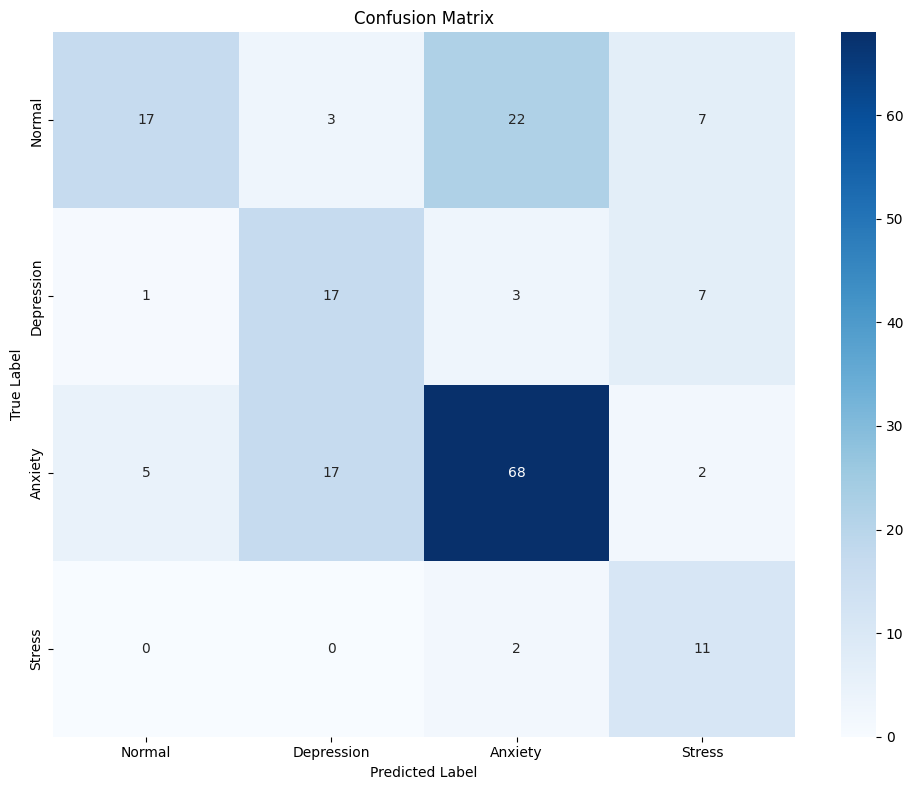


Results saved to ./classification_results.xlsx
Detailed results saved to ./classification_results.txt
Confusion matrix saved to ./classification_results.xlsx (Confusion Matrix sheet)
Classification report saved to ./classification_report.txt


In [ ]:
# Cell 6 - Import additional library for exporting to Excel
import xlsxwriter

# Update the classify_directory function to include label verification and export to Excel
def classify_directory_with_labels(model_path, scaler_path, directory_path, output_excel, results_txt):
    """
    Classify all .svc files in a directory, verify classifications against labels in filenames,
    and export results to Excel and txt
    """
    # Clear existing results file
    open(results_txt, 'w').close()
    
    results = []
    label_map = {'0': 'Normal', '1': 'Depression', '2': 'Anxiety', '3': 'Stress'}
    
    # Find all .svc files
    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    
    if not file_paths:
        raise ValueError("No .svc files found in the directory")
    
    for file_path in file_paths:
        try:
            # Extract true label from filename
            filename = os.path.basename(file_path)
            label_key = filename[0]
            true_label = label_map.get(label_key)
            
            # Classify the file
            predicted_emotion, emotion_confidences = classify_emotion(
                model_path, scaler_path, file_path, results_txt
            )
            
            # Check if the prediction is correct
            is_correct = predicted_emotion == true_label
            
            # Store the result if classification was correct
            if is_correct:
                confidence = next(conf[1] for conf in emotion_confidences if conf[0] == predicted_emotion)
                results.append({
                    'file': filename,
                    'true_label': true_label,
                    'predicted_emotion': predicted_emotion,
                    'confidence': confidence
                })
                
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Convert results to a DataFrame and export to Excel
    df_results = pd.DataFrame(results)
    with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
        df_results.to_excel(writer, sheet_name='Correct Classifications', index=False)
    
    print(f"Results saved to {output_excel} and {results_txt}")

# Cell 7 - Run the classifier with directory and export results
# Set the paths
model_path = '../trainmodel/original.keras'
scaler_path = '../trainmodel/original.save'
input_directory = '../test/test_data/'
output_excel = './classification_results.xlsx'
results_txt = './classification_results.txt'
classification_report_file = './classification_report.txt'

# Define class labels here to resolve the undefined variable issue
class_labels = ['Normal', 'Depression', 'Anxiety', 'Stress']

# Run batch classification
try:
    # Batch classify files
    classification_results, confusion_matrix_data, overall_accuracy, true_labels, predicted_labels = batch_classify_emotions(
        model_path, scaler_path, input_directory, results_txt
    )
    
    # Export results to Excel
    with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
        classification_results.to_excel(writer, sheet_name='Classification Results', index=False)
        
        # Create a separate sheet for confusion matrix
        cm_df = pd.DataFrame(confusion_matrix_data, 
                             index=['Actual ' + label for label in class_labels], 
                             columns=['Predicted ' + label for label in class_labels])
        cm_df.to_excel(writer, sheet_name='Confusion Matrix')
    
    # Generate detailed classification report
    create_classification_report(true_labels, predicted_labels, 
                                 class_labels, 
                                 classification_report_file)
    
    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix_data, class_labels)
    
    print(f"\nResults saved to {output_excel}")
    print(f"Detailed results saved to {results_txt}")
    print(f"Confusion matrix saved to {output_excel} (Confusion Matrix sheet)")
    print(f"Classification report saved to {classification_report_file}")

except Exception as e:
    print(f"Error during classification: {e}")